In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Brief Description of the Problem and Data

### Problem Description

The **Histopathologic Cancer Detection** challenge involves building a machine learning model to detect metastatic cancer in small tissue image patches extracted from digital pathology scans. This is a **binary image classification problem**:

- **Label 1**: The central **32×32 pixel region** of the image contains at least one pixel of tumor tissue.  
- **Label 0**: The central region does not contain tumor tissue.  

---

### Data Description

- There are **220,025 labeled images** are provided in the `train` folder.
- Unlabeled images are provided in the `test` folder for prediction.
- The `train_labels.csv` file maps image IDs to their corresponding binary labels (`0` or `1`).

#### Data Fields:

| Column Name | Description      |
|--------------|-----------------|
| id           | Image identifier|
| label        | 0 (No cancer) / 1 (Cancer present) |



# Exploratory Data Analysis

- The dataset contains **220,025 samples** with two columns: `id` and `label`.
- **No missing values** or **duplicate IDs** were found, indicating that the dataset is clean and ready for further analysis.
- The class distribution shows a moderate imbalance:
    - **Label 0 (No Cancer):** Approximately 130,000 samples.
    - **Label 1 (Cancer Present):** Approximately 90,000 samples.
- A **visual inspection of 5 samples from each class** was performed.  
    - Without being an expert in histopathology, it is difficult to visually identify or comment on clear differences between the two classes.

This class imbalance will be taken into account during model training by applying strategies such as:
- Using **class weights** during model fitting.
- Applying **data augmentation** on the minority class if necessary.



In [2]:
labels_df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(labels_df.shape)
labels_df.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


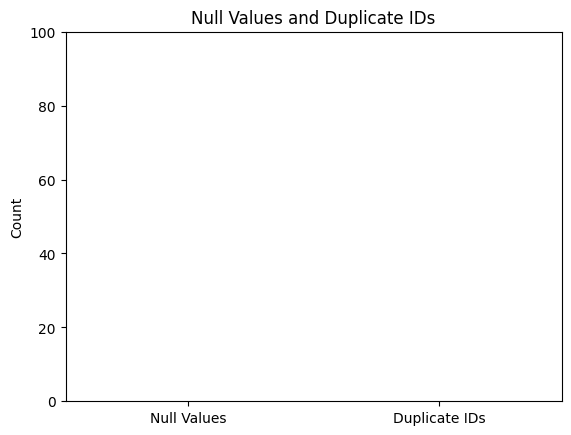

In [3]:
null_vals = labels_df.isnull().sum()
duplicate_counts = labels_df.duplicated(subset='id').sum()
issues = ['Null Values', 'Duplicate IDs']
counts = [null_vals.sum(), duplicate_counts]
plt.bar(issues, counts)
plt.title('Null Values and Duplicate IDs')
plt.ylabel('Count')
plt.ylim(0, 100)
plt.show()

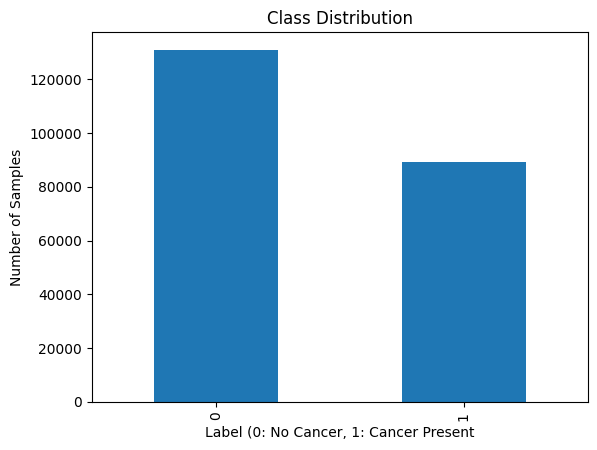

In [4]:
labels_df['label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Label (0: No Cancer, 1: Cancer Present')
plt.ylabel('Number of Samples')
plt.show()

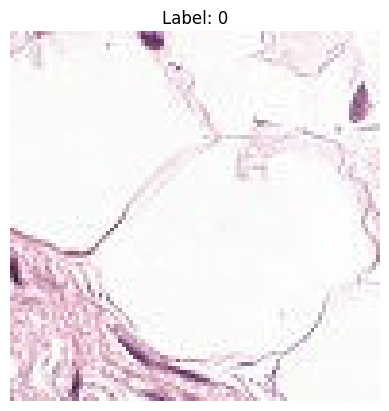

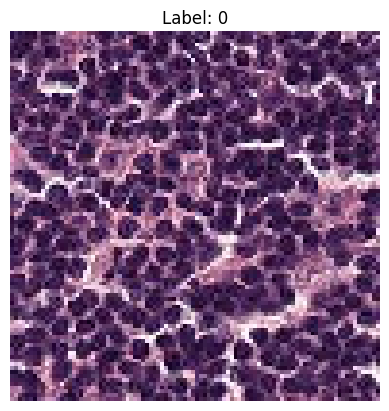

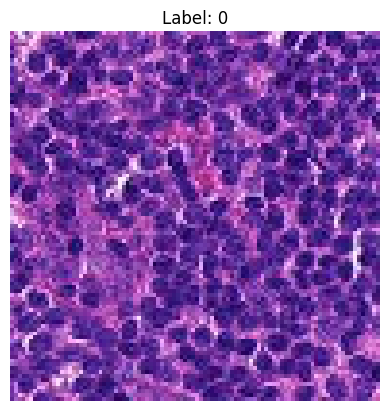

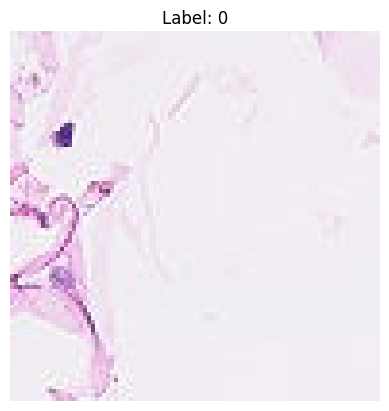

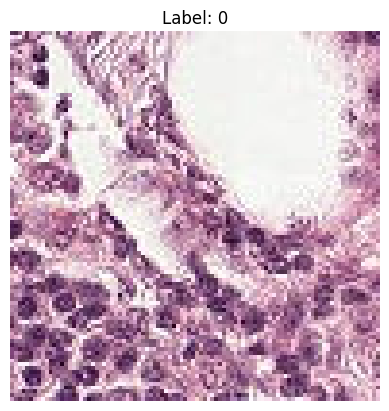

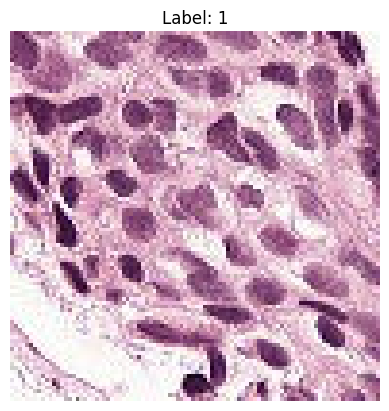

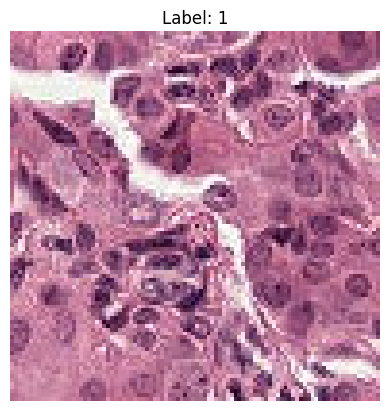

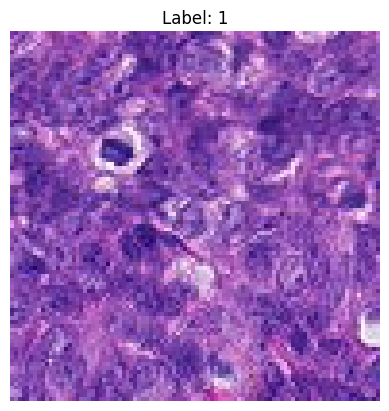

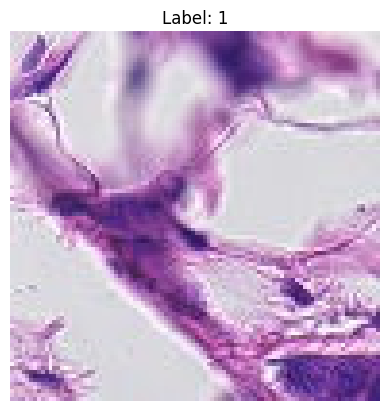

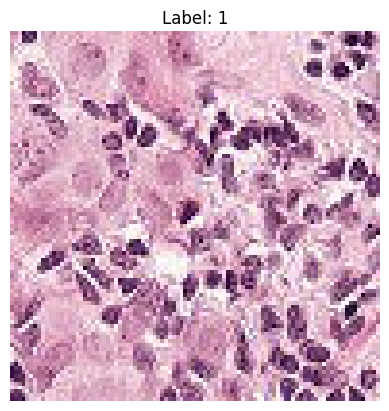

In [5]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'

def sample_images(num=5):
    label_0_ids = labels_df[labels_df['label'] == 0]['id'].sample(num).values
    label_1_ids = labels_df[labels_df['label'] == 1]['id'].sample(num).values
    all_ids = list(label_0_ids) + list(label_1_ids)
    all_labels = [0] * num + [1] * num
    for img_id, label in zip(all_ids, all_labels):
        img_path = os.path.join(train_dir, f'{img_id}.tif')
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

sample_images(num=5)

### Next Steps
- Proceed with data preprocessing and model development
- Evaluate the model using the **ROC-AUC score**, the competition's evaluation metric.

# Model

## Data Preprocessing
- Selected a **subset of 6,000 images** from the full dataset to reduce computational load and speed up experimentation.
- Used the `load_images` function to:
    - Read images directly from the `.tif` files.
    - Normalize pixel values to the range **[0, 1]** by dividing by 255.
- Applied a **stratified train-test split** to maintain balanced class distribution across training and validation sets.
    - **80% Training Data**
    - **20% Validation Data**

This ensures that both sets have a similar proportion of cancerous and non-cancerous samples, which can be important for reliable model evaluation.


In [10]:
def load_images(image_ids, dir):
    images = []
    for img_id in image_ids:
        img_path = os.path.join(dir, f'{img_id}.tif')
        img = cv2.imread(img_path)
        img = img / 255.0
        images.append(img)
    return np.array(images)

subset_size = 6000
subset_df = labels_df.sample(n=subset_size)
subset_image_ids = subset_df['id'].values
subset_labels = subset_df['label'].values

x_subset = load_images(subset_image_ids, train_dir)
y_subset = subset_labels

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    x_subset, y_subset,
    test_size = 0.2,
    stratify=y_subset
)

## Simple Model

### Model Configuration
- Simple CNN with 3 convolutional layers.
- No BatchNormalization.
- Dropout rate: 0.5 before the final Dense layer.

In [12]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

hist1 = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40  
)

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - AUC: 0.5995 - loss: 0.6667 - val_AUC: 0.8444 - val_loss: 0.5205
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8253 - loss: 0.5095 - val_AUC: 0.8748 - val_loss: 0.4498
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8281 - loss: 0.4975 - val_AUC: 0.8731 - val_loss: 0.4673
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8593 - loss: 0.4588 - val_AUC: 0.8819 - val_loss: 0.4193
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8716 - loss: 0.4405 - val_AUC: 0.8870 - val_loss: 0.4211
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8670 - loss: 0.4467 - val_AUC: 0.8887 - val_loss: 0.4215
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8697 - loss: 0.4434 - val_AUC: 0.8828 - val_loss: 0.4196
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - AUC: 0.8807 - loss: 0.4245 - val_AUC: 0.8825 - val_loss: 0.4229
Epoch 9/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/

### Observations
- Training AUC quickly reached **~0.99**, indicating the model fits the training data very well.
- Validation AUC plateaued at **~0.82–0.84**.
- Validation loss steadily increased after Epoch 15, confirming **overfitting**.
- Despite continued training, validation performance did not improve, indicating the model learned noise rather than generalizable patterns.

### Conclusions
- The baseline model performs reasonably well initially but starts overfitting quickly.
- There is clear room for improvement. 


## Batch Normalization Model

### Model Configuration
- Added **BatchNormalization** after each convolutional layer.
- Dropout rate: 0.5 before the final Dense layer.


In [13]:
cnn_bn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_bn_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

hist2 = cnn_bn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40  
)

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - AUC: 0.7493 - loss: 1.7680 - val_AUC: 0.6337 - val_loss: 5.0959
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - AUC: 0.8355 - loss: 0.5196 - val_AUC: 0.7194 - val_loss: 1.9493
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8688 - loss: 0.4735 - val_AUC: 0.8248 - val_loss: 1.2046
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8929 - loss: 0.4147 - val_AUC: 0.8839 - val_loss: 0.6487
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8877 - loss: 0.4252 - val_AUC: 0.9102 - val_loss: 0.3835
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.9118 - loss: 0.3750 - val_AUC: 0.8604 - val_loss: 0.5793
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.9228 - loss: 0.3457 - val_AUC: 0.9065 - val_loss: 0.3823
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.9409 - loss: 0.3113 - val_AUC: 0.9041 - val_loss: 0.4507
Epoch 9/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms

### Observations
- Training AUC quickly reached **~0.99**, indicating the model fits the training data very well.
- However, after ~Epoch 10, validation AUC plateaued and fluctuated between with the average being around**0.84–0.86**.
- Validation loss increased steadily after Epoch 10, confirming **overfitting** despite BatchNormalization.
- BatchNormalization improved early training stability but did not fully mitigate overfitting.

### Conclusions
- BatchNormalization slightly improved validation performance compared to the simple baseline model (from ~0.82–0.84 up to ~0.86).
- Overfitting is still a major issue, suggesting further regularization or architectural changes are needed.


## Dropout and Batch Normalization Model

### Model Configuration
- Added **BatchNormalization** after each convolutional layer.
- Increased **Dropout rate** from 0.5 to **0.7** before the final Dense layer.

In [14]:
cnn_bn_dp_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.7),
    Dense(1, activation='sigmoid')
])
cnn_bn_dp_model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['AUC']
)

hist3 = cnn_bn_dp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40  
)

Epoch 1/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - AUC: 0.7264 - loss: 1.6500 - val_AUC: 0.3132 - val_loss: 3.3034
Epoch 2/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8252 - loss: 0.5325 - val_AUC: 0.6524 - val_loss: 2.2166
Epoch 3/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8747 - loss: 0.4544 - val_AUC: 0.7801 - val_loss: 1.0512
Epoch 4/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8681 - loss: 0.4541 - val_AUC: 0.8112 - val_loss: 0.6687
Epoch 5/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8861 - loss: 0.4419 - val_AUC: 0.7172 - val_loss: 0.9316
Epoch 6/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8803 - loss: 0.4508 - val_AUC: 0.8925 - val_loss: 0.4533
Epoch 7/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.8887 - loss: 0.4380 - val_AUC: 0.8604 - val_loss: 0.5048
Epoch 8/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - AUC: 0.9036 - loss: 0.3930 - val_AUC: 0.4849 - val_loss: 2.0674
Epoch 9/40
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms

### Observations
- **Training AUC** reached **~0.99** by around Epoch 20, slightly slower than previous models.
- **Validation AUC** improved compared to previous models, peaking around **0.89–0.90**.
- Overfitting occurred later in training compared to prior experiments, indicating that the higher Dropout delayed overfitting.

### Conclusions
- Increasing Dropout to **0.7** had a **positive impact**, reducing early overfitting and achieving higher validation AUC than previous experiments.
- However, the model still overfits, meaning additional regularization or architectural adjustments are needed for further improvement.


# Results and Analysis

### Validation AUC Comparison

The plot below compares the Validation AUC across different models and training epochs:

- **Simple CNN (Dropout 0.5)** achieved stable AUC values around **0.85**, with minimal fluctuations.
- **CNN + BatchNorm (Dropout 0.5)** reached slightly higher AUC values (~0.90) but showed higher variance and signs of overfitting.
- **CNN + BatchNorm (Dropout 0.7)** introduced stronger regularization, delaying overfitting.

_Conclusion_: Increasing Dropout delayed overfitting and stabilized AUC but also slightly limited the maximum AUC achievable.

---

### Validation Loss Comparison

The plot below shows how Validation Loss varied over training epochs:

- The **Simple CNN** model maintained low and consistent validation loss throughout training.
- **CNN + BatchNorm (Dropout 0.5)** showed unstable loss behavior, including sharp spikes, indicating overfitting and poor generalization at certain epochs.
- **CNN + BatchNorm (Dropout 0.7)** reduced the instability in loss but still experienced some fluctuation.

_Conclusion_: While BatchNormalization helped in stabilizing early training, higher Dropout further improved regularization and reduced extreme validation loss spikes.


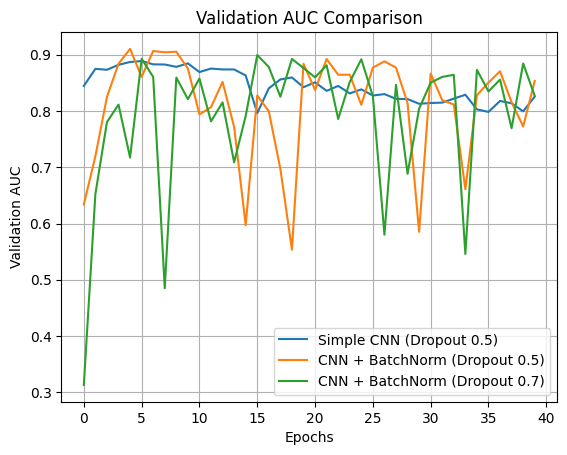

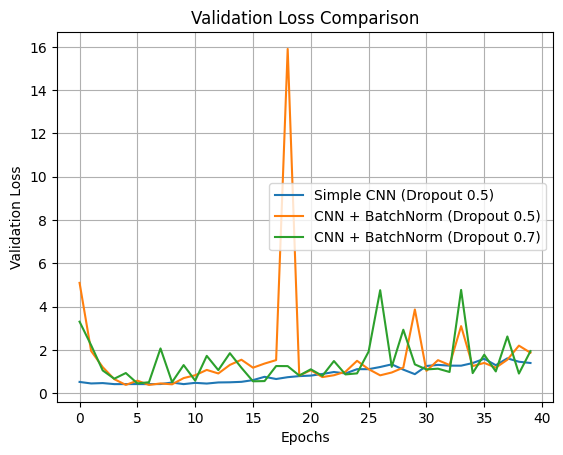

In [18]:
plt.plot(hist1.history['val_AUC'], label='Simple CNN (Dropout 0.5)')
plt.plot(hist2.history['val_AUC'], label='CNN + BatchNorm (Dropout 0.5)')
plt.plot(hist3.history['val_AUC'], label='CNN + BatchNorm (Dropout 0.7)')

plt.title('Validation AUC Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation AUC')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(hist1.history['val_loss'], label='Simple CNN (Dropout 0.5)')
plt.plot(hist2.history['val_loss'], label='CNN + BatchNorm (Dropout 0.5)')
plt.plot(hist3.history['val_loss'], label='CNN + BatchNorm (Dropout 0.7)')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
results_summary = pd.DataFrame({
    'Model': [
        'Simple CNN (Dropout 0.5)',
        'CNN + BatchNorm (Dropout 0.5)',
        'CNN + BatchNorm (Dropout 0.7)'
    ],
    'Best Validation AUC': [
        max(hist1.history['val_AUC']),
        max(hist2.history['val_AUC']),
        max(hist3.history['val_AUC'])
    ],
    'Epoch of Best AUC': [
        hist1.history['val_AUC'].index(max(hist1.history['val_AUC'])) + 1,
        hist2.history['val_AUC'].index(max(hist2.history['val_AUC'])) + 1,
        hist3.history['val_AUC'].index(max(hist3.history['val_AUC'])) + 1
    ]
})
results_summary

,Model,Best Validation AUC,Epoch of Best AUC
0,Simple CNN (Dropout 0.5),0.888665,6
1,CNN + BatchNorm (Dropout 0.5),0.910179,5
2,CNN + BatchNorm (Dropout 0.7),0.899271,16


**Key Takeaways:**
- The model with **BatchNormalization and Dropout 0.5** achieved the highest AUC, but overfitting occurred very early (by Epoch 5).
- Increasing Dropout to **0.7** delayed overfitting to **Epoch 16**, leading to better stability, though peak AUC was slightly lower.
- The **Simple CNN** performed consistently but didn't achieve the highest AUC.


# Conclusion

### Results Interpretation
- The **Simple CNN (Dropout 0.5)** provided a strong baseline, achieving a peak validation AUC of **0.8887** by Epoch 6. However, the model began overfitting shortly after and failed to improve further despite continued training.
- Adding **BatchNormalization (Dropout 0.5)** improved the model’s learning speed and peak AUC to **0.9102**, but overfitting occurred even earlier, by Epoch 5. While BatchNormalization stabilized early training, it also accelerated overfitting without additional regularization.
- Increasing the **Dropout rate to 0.7** successfully delayed overfitting until **Epoch 16** and improved training stability. However, the maximum validation AUC achieved was slightly lower at **0.8993**. This suggests that higher Dropout improves generalization but can also limit the model's capacity if set too high.

### What Helped Improve Performance
- Adding **BatchNormalization** helped the model learn faster and initially improved performance.
- Increasing **Dropout** effectively delayed overfitting and stabilized the validation loss, allowing for longer and more productive training.

### What Did not Help Improve Performance
- Training for more epochs beyond the optimal point consistently led to overfitting and worse validation performance.
- Simply adding BatchNormalization without adjusting regularization parameters resulted in early overfitting.
- High model complexity relative to the small dataset size (6,000 images) limited the potential for significant improvements.

### Future Improvement Ideas
- Introduce **EarlyStopping** to automatically halt training when validation performance stops improving, preventing unnecessary overfitting.
- Experiment with **lower learning rates** to slow down weight updates.
- Try **reducing Dense layer size** (such as from 128 to 64 units) to lower model complexity.

### Takeaway
Careful balancing of model complexity and regularization is crucial, especially when working with limited data. While BatchNormalization and Dropout both contributed positively, fine-tuning their use together with optimization strategies like EarlyStopping and learning rate adjustments are key to performance improvements.